# Funcionalidad principal de [banrep][pypi_banrep]
[pypi_banrep]: https://pypi.org/project/banrep/

## Requerimientos

### Importamos las otras librerías utilizadas en este ejemplo

In [1]:
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
import plotly.offline as pyo
import spacy

### Y lo que usaremos de la librería [banrep][pypi_banrep]
[pypi_banrep]: https://pypi.org/project/banrep/

In [2]:
from banrep.corpus import MiCorpus
from banrep.io import Textos, leer_palabras
from banrep.topicos import Topicos
from banrep.utils import crear_directorio

### Necesitamos un modelo NLP para español de [spaCy][spacy_models]
[spacy_models]: https://spacy.io/models

In [3]:
nlp = spacy.load('es_core_news_md')

## Preprocesamiento de texto y filtros

### Textos a usar

Se asume una carpeta en disco en la que hay archivos de texto. Si los textos que quiere utilizar están en archivos binarios como *.pdf*, *.docx*, etc., debe primero [extraer el texto][extraccion].

[extraccion]: https://munozbravo.github.io/banrep/uso_extraccion/

#### Uso de clase: `Textos`

Se usa para iterar los archivos de texto en disco.

Argumento `rutadatos` especifica ubicación de los textos en disco (parámetro `directorio`).

Parámetro `chars` filtra aquellas líneas de texto de cada archivo cuya longitud sea inferior al valor especificado. *69* es valor arbitrario que permite filtrar la mayoría de títulos y subtítulos.

Parámetro `parrafos` permite definir si se considera cada párrafo como un documento separado.

Parámetro `aleatorio` sirve cuando se quiere iterar los archivos aleatoriamente.

In [4]:
rutadatos = '../datasets/'

datos = Textos(rutadatos, aleatorio=False, chars=69, parrafos=True)
print(datos)

29 archivos en directorio datasets.


### Filtros: palabras y tokens a ignorar

Generalmente se quiere ignorar palabras comunes a todos los textos, llamadas *stopwords*, por no aportar al entendimiento de los diferentes textos.

Se obtendrá información detallada de cada palabra gracias a [spaCy][web_spacy], lo que permite filtrar adicionalmente por criterios como [categoría gramatical][universal] (verbos, sustantivos, etc), si es algún tipo de [nombre propio][spacy_ents] (Juan, Colombia, Banco de la República), o si contiene caracteres que no hacen parte del alfabeto (números, monedas, etc). 

[web_spacy]: https://spacy.io/
[universal]: https://universaldependencies.org/es/index.html
[spacy_ents]: https://spacy.io/api/annotation#named-entities

#### Uso de función: `leer_palabras`

Permite leer categorías de palabras de un archivo excel. 
En este caso, una sola categoría (stopwords).

Parámetros `archivo` y `hoja` determinan el archivo excel en disco, y la hoja a usar.

Parámetro `col_grupo` es el nombre de una columna en la hoja excel que determina el grupo al que pertenecen las palabras.

Parámetro `col_palabras` es el nombre de una columna en la hoja excel que contiene las palabras.

In [5]:
rutastops = '~/Dropbox/datasets/wordlists/stopwords.xlsx'
palabras = leer_palabras(archivo=rutastops, 
                         hoja='banrep_es', 
                         col_grupo="type", 
                         col_palabras="word")

stops = palabras.get("stopword")

#### Ilustración para mayor claridad

La hoja de stopwords en mi archivo excel...

![](img/stopwords.png)


En este caso elimino de cualquier análisis posterior todas las *stopwords* del archivo excel, las categorías gramaticales que identifican números, puntuación y símbolos, y aquellas "palabras" o tokens que contengan caracteres que no hacen parte del alfabeto.

In [6]:
tags = ['NUM', 'PUNCT', 'SYM']

filtros = dict(stopwords=stops, postags=tags, entities=None, is_alpha=True)

## Dimensiones adicionales que se quieren medir

### Pertenencia a listas de palabras predefinidas

Muchas veces se quiere contabilizar cuantas palabras de cada documento hacen parte de listas de palabras predefinidas. Por ejemplo, puedo tener listas de palabras "positivas" y "negativas", y querer contar cuantas palabras de los textos que voy a analizar hacen parte de estas listas. Esto sirve, por ejemplo, para crear indicadores de sentimiento basados en el conteo de palabras que pertenecen a emociones "contrarias".

#### Uso de función: `leer_palabras`

La misma función usada para cargar *stopwords* nos sirve para leer un archivo excel que contiene otras categorías de palabras, en este caso palabras que denotan *mejora* y otras que denotan *deterioro*.

In [7]:
rutawl = '~/Dropbox/datasets/wordlists/sentimiento.xlsx'
wordlists = leer_palabras(rutawl, 'BANREP', col_grupo="type", col_palabras="word")

# Cuantas palabras en cada grupo...
for tipo in wordlists:
    print(f'{len(wordlists.get(tipo))} palabras en grupo {tipo}')

1899 palabras en grupo deterioro
359 palabras en grupo mejora


## Corpus y sus estadísticas

### Crear el corpus

Un *corpus* es un conjunto de documentos, para el cual queremos obtener toda clase de estadísticas.

`MiCorpus` es la implementación de un corpus, el cual se inicializa con un modelo [spaCy][spacy_models] y un objeto `Textos`, y opcionalmente con los filtros especificados anteriormente, las listas de palabras que se quiere contar, y expresiones que se quiere encontrar. 

[spacy_models]: https://spacy.io/models

#### Uso de clase: `MiCorpus`

Se usa para inicializar el corpus. Es la estructura más importante de [banrep][pypi_banrep].

Argumento `nlp` es el modelo spaCy (parámetro `lang`).

Parámetro `datos` es el objeto Textos creado anteriormente en la variable *datos*.

Parámetros `filtros` y `wordlists` ya explicados anteriormente.

Parámetro `corta` sirve como filtro adicional, ignorando frases de pocos tokens (palabras, puntuación, símbolos, números, etc. En este ejemplo, frases con menos de 10 tokens).

[pypi_banrep]: https://pypi.org/project/banrep/

In [8]:
corpus = MiCorpus(nlp, datos=datos, filtros=filtros, corta=9, wordlists=wordlists)
print(corpus)

Corpus con 5628 docs y 3619 palabras únicas.


### Estadísticas de corpus

#### Estadísticas agregadas

In [9]:
stats = corpus.corpus_stats()
stats.tail()

,doc_id,archivo,fuente,frases,palabras
5623,005624,2005-12.txt,inflacion,1,7
5624,005625,2005-12.txt,inflacion,2,16
5625,005626,2005-12.txt,inflacion,3,46
5626,005627,2005-12.txt,inflacion,3,60
5627,005628,2005-12.txt,inflacion,2,26


#### Estadísticas desagregadas por token

In [10]:
tokens = corpus.corpus_tokens()
tokens.tail()

,doc_id,sent_id,tok_id,word,pos,ok_token,deterioro,mejora
173906,005628,2,12,esquema,NOUN,True,False,False
173907,005628,2,13,intervención,NOUN,True,False,False
173908,005628,2,14,discrecional,ADJ,True,False,False
173909,005628,2,15,mercado,NOUN,True,False,False
173910,005628,2,16,cambiario,ADJ,True,False,False


In [11]:
con_ngrams = corpus.corpus_ngramed()
con_ngrams.head(10)

,doc_id,sent_id,tok_id,word
0,000001,1,1,términos
1,000001,1,2,referencia
2,000001,1,3,decisiones
3,000001,1,4,política_monetaria
4,000001,1,5,junta_directiva_banco_república
5,000001,1,6,periódicamente
6,000001,1,7,análisis
7,000001,1,8,detallado
8,000001,1,9,resultados
9,000001,1,10,inflación


#### Estadísticas desagregadas por frase

In [12]:
stats_frases = corpus.frases_stats()
stats_frases.head(10)

,doc_id,sent_id,ok_span,ok_token,deterioro,mejora
0,000001,1,True,18,0,0
1,000002,1,True,17,0,0
2,000003,1,True,17,0,0
3,000003,2,True,9,0,0
4,000004,1,True,13,0,0
5,000005,1,True,8,0,0
6,000005,2,True,7,0,0
7,000005,3,True,15,0,0
8,000005,4,True,10,0,0
9,000005,5,True,18,0,1


## Modelos de tópicos y su visualización

### Crear modelos LDA

Los modelos de tópicos se usan para encontrar "temáticas" subyacentes en los textos.

El parámetro básico a especificar en un modelo es el número de tópicos que se quiere considerar en el resultado.

Esta librería usa [Gensim][web_gensim] para la implementación del cálculo de los modelos. En su [documentación][gensim_tuts] encontrará todo lo necesario para correr este tipo de modelos y muchas técnicas adicionales no usadas en esta librería. [banrep][pypi_banrep] simplemente ofrece funciones para correr varios modelos LDA y seleccionar el mejor, todo basado en Gensim.

[web_gensim]: https://radimrehurek.com/gensim/models/ldamodel.html
[gensim_tuts]: https://radimrehurek.com/gensim/tutorial.html
[pypi_banrep]: https://pypi.org/project/banrep/

#### Uso de clase: `Topicos`

Se usa para crear modelos lda para diferentes números de tópicos.

Argumento `corpus` es una instancia de `MiCorpus`, y `n_topicos` es una lista de números para los cuales se quiere generar un modelo.

Parámetro `params` es un diccionario con parámetros que se usan en la [implementación LDA de Gensim][lda_gensim] (gensim.models.ldamodel.LdaModel).

Los modelos de tópicos suelen ser evaluados usando una medida llamada *Coherence Score*. Esta medida sugiere qué tan "interpretables" son los modelos. Un mayor score es un modelo más "interpretable", y por lo tanto mejor.

`Topicos` permite acceso a todos los modelos generados, y el mejor según Coherence Score se puede seleccionar usando el método `mejor_modelo`.  

[lda_gensim]: https://radimrehurek.com/gensim/models/ldamodel.html

In [13]:
n_topicos = (5, 10, 15)
params = dict(passes=5, alpha='auto', eta='auto', random_state=100)

topicos = Topicos(corpus, n_topicos, params)
print(topicos)

Modelos LDA para valores k en (5, 10, 15): mejor k=10 (Coherence=0.4596)


In [14]:
modelo = topicos.mejor_modelo()

### Visualización PyLDAvis (opcional)

En análisis de tópicos se suele usar PyLDAvis para visualizar resultados de un modelo.

La visualización es muy útil para entender la diferencia entre tópicos (distancia entre los círculos de la gráfica en costado izquierdo), prevalencia de cada tópico (tamaño de cada círculo), y el contenido de cada tópico (palabras más probables desplegadas en costado derecho para cada círculo).

El único "*pero*" es que suele generar advertencias de uso "obsoleto" (DeprecationWarning).

In [15]:
import warnings

import pyLDAvis
import pyLDAvis.gensim

# Gráfica LDAvis de tópicos y sus palabras
bow = list(corpus)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    vis = pyLDAvis.gensim.prepare(modelo, bow, corpus.id2word, sort_topics=False)

In [16]:
pyLDAvis.display(vis)

### Alternativa a PyLDAvis (opcional)

Para entender diferencia entre tópicos también se puede usar un *heatmap*, en el que cada celda representa la "distancia" entre dos tópicos. 

Este, unido a las *Estadísticas de Modelo de tópicos* mencionadas abajo, provee la misma información que PyLDAvis.

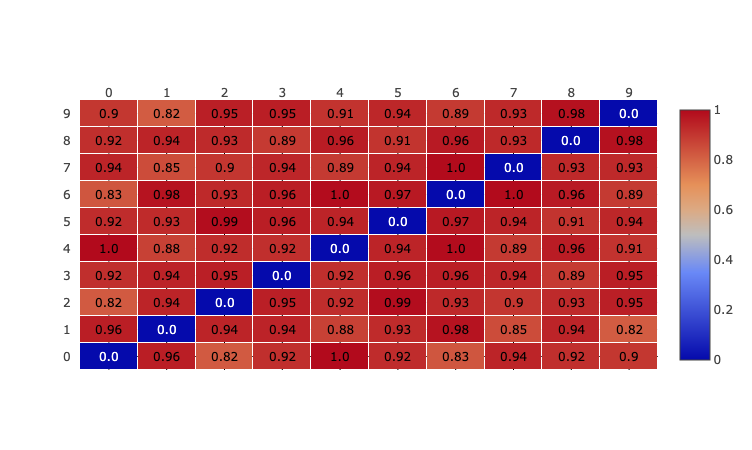

In [17]:
k = modelo.num_topics
diferencia, notas = modelo.diff(modelo, distance="hellinger", annotation=False)
anno_text = np.around(diferencia, decimals=2)

fig = ff.create_annotated_heatmap(z=diferencia, annotation_text=anno_text, 
                                  x=list(range(k)), y=list(range(k)), xgap=1, ygap=1,
                                  showscale=True, 
                                  )

pyo.iplot(fig)

## Estadísticas de Modelo de tópicos

### Distribución de probabilidad de tópicos en documentos

Usualmente se quiere ver la probabilidad de cada tópico asociada a cada documento. Se puede  pensar un documento como generado de una distribución de probabilidad de tópicos. 

El método `stats_topicos` devuelve dicha distribución. Para cada documento (fila) muestra la  probabilidad de que hable de cada tópico (columna).

Basado en esta distribución, el método también devuelve la "prevalencia" de cada tópico: en cuantos documentos del corpus es dominante.

#### Uso de método: `stats_topicos`

Parámetro `modelo` es un modelo LDA.

In [18]:
doctopics, dominante = topicos.stats_topicos(modelo)

In [19]:
doctopics.tail()

,0,1,2,3,4,5,6,7,8,9
005624,0.262847,0.010089,0.014023,NaN,0.010598,0.011491,0.013072,0.465592,NaN,0.193156
005625,0.952283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
005626,0.580739,NaN,0.107427,NaN,NaN,0.132913,NaN,NaN,NaN,0.165784
005627,0.498586,0.029520,0.044318,NaN,NaN,NaN,0.293340,NaN,0.026698,0.102251
005628,NaN,NaN,NaN,NaN,NaN,0.726834,0.238132,NaN,NaN,NaN


In [20]:
dominante.head()

topico
9    0.230
2    0.151
0    0.111
4    0.101
5    0.088
dtype: float64

### Distribución de probabilidad de palabras en cada tópico

#### Uso de método: `palabras_probables`

Genera un DataFrame con las palabras más probables de cada tópico en un modelo.

Parámetro `modelo` es un modelo LDA y `n` indica cuantas palabras se quiere incuir en el resultado.

In [21]:
palabras = topicos.palabras_probables(modelo, n=20)

In [22]:
palabras.head(10)

,palabra,probabilidad,topico
0,inflación,0.063274,0
1,expectativas,0.017786,0
2,pronóstico,0.014863,0
3,pronósticos,0.012625,0
4,tasas_interés,0.011372,0
5,inflación_alimentos,0.010558,0
6,meta,0.010297,0
7,política_monetaria,0.010153,0
8,precios,0.009975,0
9,nivel,0.008861,0


## Almacenamiento de objetos generados

### Criterios

El corpus y los modelos de tópicos generan estructuras que pueden ser útiles más adelante, y por lo tanto se quiere guardar a disco.

Se quiere usualmente almacenar modelos de "ngramas", el "diccionario" que contiene todas las palabras únicas existentes en el corpus, y el mejor modelo de tópicos opcionalmente con  su visualización.

#### Uso de función: `crear_directorio`

`crear_directorio` simplemente crea un directorio en disco, en el que se quiere guardar las estructuras generadas. En este caso se quiere crear directorio de salida para estructuras generales, y opcionalmente uno diferente para el mejor modelo.

In [23]:
# Crear directorio de salida
dirsalida = crear_directorio('topicos')

# Crear directorio para mejor modelo.
dirmodelo = crear_directorio(dirsalida.joinpath(f'{topicos.top_k:0>2}'))

### Guardar n-gramas y diccionario generados en corpus

In [24]:
#Guardar modelos de bigramas y trigramas
corpus.ngrams.get('bigrams').save(str(dirsalida.joinpath('bigrams')))
corpus.ngrams.get('trigrams').save(str(dirsalida.joinpath('trigrams')))

# Guardar diccionario
corpus.id2word.save(str(dirsalida.joinpath('id2word')))

### Guardar mejor modelo LDA y su visualización

In [25]:
modelo.save(str(dirmodelo.joinpath('topicos.lda')))
pyLDAvis.save_html(vis, str(dirmodelo.joinpath('topicos.html')))